In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import seaborn as sns
sns.set_style(style="whitegrid")
import matplotlib.pyplot as plt

In [2]:
df_well_being_raw = pd.read_excel("data/london-ward-well-being-probability-scores.xls", sheet_name="Scores")
df_grocery_raw = pd.read_csv('data/year_osward_grocery.csv')

In [3]:
df_well = df_well_being_raw[["Unnamed: 1", "Subjective well-being average score.4", "Life Expectancy.4"]]
df_well.columns = ['area_id', 'well_being', 'life_expectancy']
df_well = df_well.drop(0)
df_well = df_well.dropna()

In [4]:
#df_grocery = df_grocery_raw[["area_id", "fat", "saturate", "salt", "sugar", "protein", "carb", "fibre", "alcohol"]]
df_grocery = df_grocery_raw[["area_id", "fat", "saturate", "salt", "sugar", "protein", "carb", "fibre", "alcohol", "energy_fat", "energy_saturate","energy_sugar", 
                             "energy_protein", "energy_carb", "energy_fibre", "energy_alcohol", "energy_tot", "h_nutrients_calories_norm",
                            'f_beer', 'f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains', 'f_meat_red', 'f_poultry',
                             'f_readymade', 'f_sauces', 'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_tea_coffee', 'f_water', 'f_wine']]

nutrients = ["fat", "protein", "carb", "fibre", "alcohol"]
df_grocery_percentage = df_grocery.copy()
for i, nutrient in enumerate (nutrients):
    df_grocery_percentage["percentage_%s"%nutrient] = df_grocery_percentage["energy_%s"%nutrient] *100 / df_grocery["energy_tot"]
    


In [5]:
df_grocery_percentage.head()

,area_id,fat,saturate,salt,sugar,protein,carb,fibre,alcohol,energy_fat,...,f_spirits,f_sweets,f_tea_coffee,f_water,f_wine,percentage_fat,percentage_protein,percentage_carb,percentage_fibre,percentage_alcohol
0,E05000026,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,0.198172,85.399176,...,0.004656,0.181254,0.005945,0.042942,0.007917,45.640000,10.640657,41.433292,1.544686,0.741364
1,E05000027,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,0.209917,87.602703,...,0.005180,0.173620,0.005572,0.041258,0.007355,46.439549,11.051200,40.183491,1.546797,0.778963
2,E05000028,9.216310,3.613582,0.610536,10.690272,5.192412,19.662048,1.572323,0.225425,82.946787,...,0.003657,0.179634,0.006076,0.043609,0.009281,44.389378,11.114978,42.088964,1.562220,0.844460
3,E05000029,9.700137,3.961264,0.533180,12.938606,4.718184,20.084734,1.550344,0.200380,87.301229,...,0.004576,0.216788,0.006578,0.046902,0.007344,45.759214,9.892203,42.109906,1.503467,0.735209
4,E05000030,9.381808,3.614663,0.566784,11.332898,5.307003,19.581403,1.607947,0.168952,84.436271,...,0.002538,0.189401,0.006638,0.039688,0.009738,44.880395,11.283322,41.632398,1.575264,0.628621


In [6]:
df = df_well.merge(df_grocery_percentage, on='area_id')

In [7]:
df.head()

,area_id,well_being,life_expectancy,fat,saturate,salt,sugar,protein,carb,fibre,...,f_spirits,f_sweets,f_tea_coffee,f_water,f_wine,percentage_fat,percentage_protein,percentage_carb,percentage_fibre,percentage_alcohol
0,E05000026,6.118185,4.251859,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,...,0.004656,0.181254,0.005945,0.042942,0.007917,45.640000,10.640657,41.433292,1.544686,0.741364
1,E05000027,-4.726708,-9.035117,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,...,0.005180,0.173620,0.005572,0.041258,0.007355,46.439549,11.051200,40.183491,1.546797,0.778963
2,E05000028,-4.813479,-7.975613,9.216310,3.613582,0.610536,10.690272,5.192412,19.662048,1.572323,...,0.003657,0.179634,0.006076,0.043609,0.009281,44.389378,11.114978,42.088964,1.562220,0.844460
3,E05000029,-4.813479,-1.211477,9.700137,3.961264,0.533180,12.938606,4.718184,20.084734,1.550344,...,0.004576,0.216788,0.006578,0.046902,0.007344,45.759214,9.892203,42.109906,1.503467,0.735209
4,E05000030,-4.726708,-8.051658,9.381808,3.614663,0.566784,11.332898,5.307003,19.581403,1.607947,...,0.002538,0.189401,0.006638,0.039688,0.009738,44.880395,11.283322,41.632398,1.575264,0.628621


In [8]:
spearman_nutrients = {}
spearman_weight = {}
spearman_energy = {}

for nutrient in nutrients:
    spearman_nutrients[nutrient] = stats.spearmanr(df["percentage_%s"%nutrient],df['well_being'])
    spearman_weight[nutrient] = stats.spearmanr(df["%s"%nutrient],df['well_being'])
    spearman_energy[nutrient] = stats.spearmanr(df["energy_%s"%nutrient],df['well_being'])
    
spearman_entropy = stats.spearmanr(df["h_nutrients_calories_norm"],df['well_being'])

In [9]:
# Fit linear regression model to nutrients
mod = smf.ols(formula='well_being ~  fat + sugar + alcohol + carb + saturate + protein + fibre', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.467
Date:                Tue, 15 Dec 2020   Prob (F-statistic):              0.177
Time:                        17:50:15   Log-Likelihood:                -1784.5
No. Observations:                 483   AIC:                             3585.
Df Residuals:                     475   BIC:                             3618.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.3516     19.021     -0.387      0.6

In [10]:
# Fit logistic regression model to foods
mod = smf.ols(formula='well_being ~  f_beer + f_dairy + f_eggs + f_fats_oils+f_fish+f_fruit_veg+f_grains+f_meat_red+f_poultry+f_readymade + f_sauces+f_soft_drinks+f_spirits+f_sweets+f_tea_coffee+f_water+f_wine', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             well_being   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     3.257
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           2.18e-05
Time:                        17:50:15   Log-Likelihood:                -1764.0
No. Observations:                 483   AIC:                             3562.
Df Residuals:                     466   BIC:                             3633.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -28.1847     42.416     -0.664

In [11]:
### Let's build a healhty diet according to https://en.wikipedia.org/wiki/Healthy_diet

foods = dict(zip(["fruit_veg", "grains", "dairy", "meat_red", "poultry", "eggs", "fish"], [4.5, 0.75, 3, 1.5/7, 1.25/7, 0.375/7, 1/7]))
sum_values = sum(foods.values())

for food in foods.keys():
    foods[food] = foods[food]/sum_values

In [12]:
foods

{'fruit_veg': 0.5090909090909091,
 'grains': 0.08484848484848485,
 'dairy': 0.3393939393939394,
 'meat_red': 0.024242424242424242,
 'poultry': 0.020202020202020204,
 'eggs': 0.006060606060606061,
 'fish': 0.01616161616161616}

In [13]:
df_healthy = df.copy()
df_healthy.loc[:,"score"] =0
for food in foods:
    df_healthy["score"] += (df_healthy["f_%s"%food] - foods[food])**2
    

In [14]:
df_healthy.head()

,area_id,well_being,life_expectancy,fat,saturate,salt,sugar,protein,carb,fibre,...,f_sweets,f_tea_coffee,f_water,f_wine,percentage_fat,percentage_protein,percentage_carb,percentage_fibre,percentage_alcohol,score
0,E05000026,6.118185,4.251859,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,...,0.181254,0.005945,0.042942,0.007917,45.640000,10.640657,41.433292,1.544686,0.741364,0.125700
1,E05000027,-4.726708,-9.035117,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,...,0.173620,0.005572,0.041258,0.007355,46.439549,11.051200,40.183491,1.546797,0.778963,0.130958
2,E05000028,-4.813479,-7.975613,9.216310,3.613582,0.610536,10.690272,5.192412,19.662048,1.572323,...,0.179634,0.006076,0.043609,0.009281,44.389378,11.114978,42.088964,1.562220,0.844460,0.138758
3,E05000029,-4.813479,-1.211477,9.700137,3.961264,0.533180,12.938606,4.718184,20.084734,1.550344,...,0.216788,0.006578,0.046902,0.007344,45.759214,9.892203,42.109906,1.503467,0.735209,0.152978
4,E05000030,-4.726708,-8.051658,9.381808,3.614663,0.566784,11.332898,5.307003,19.581403,1.607947,...,0.189401,0.006638,0.039688,0.009738,44.880395,11.283322,41.632398,1.575264,0.628621,0.139938


In [15]:
stats.spearmanr(df_healthy["score"],df_healthy['well_being'])

SpearmanrResult(correlation=0.09502979534896164, pvalue=0.036814974492699666)

In [16]:
### Let's build a healhty diet according to https://www.fda.gov/media/135301/download

foods_fda_updated = dict(zip(["fat", "fibre", "carb", "protein", "saturate"], [78, 28, 275, 50, 20]))
foods_fda_old = dict(zip(["fat", "fibre", "carb", "protein", "saturate"], [65, 25, 300, 50, 20]))

#saturate is included in fat
sum_values_fda_updated = sum(list(foods_fda_updated.values())[:-1])
sum_values_fda_old = sum(list(foods_fda_old.values())[:-1])

for food in foods_fda_updated.keys():
    foods_fda_updated[food] = foods_fda_updated[food]/sum_values_fda_updated
    foods_fda_old[food] = foods_fda_old[food]/sum_values_fda_old

In [17]:
df_fda = df_healthy[["area_id", "well_being", "life_expectancy", "fat", "fibre", "carb", "protein", "saturate"]]

df_fda_percentage = df_fda.copy()

#2:5 --> not the saturated for the sum because they are included in fat
df_fda_percentage["weight_tot"] = df_fda.iloc[:,3:6].sum(axis=1)

#2:6 --> only for nutrients
for nutrient in df_fda_percentage.columns[3:8]:
    df_fda_percentage["percentage_%s"%nutrient] = df_fda_percentage["%s"%nutrient] / df_fda_percentage["weight_tot"]

In [18]:
df_fda_percentage.loc[:,"score"] =0
for nutrient in  df_fda_percentage.columns[3:8]:
    df_fda_percentage["score"] += (df_fda_percentage["percentage_%s"%nutrient] - foods_fda_updated[nutrient])**2
    df_fda_percentage["score"] = 1 - df_fda_percentage["score"]

In [19]:
df_fda_percentage.head()

,area_id,well_being,life_expectancy,fat,fibre,carb,protein,saturate,weight_tot,percentage_fat,percentage_fibre,percentage_carb,percentage_protein,percentage_saturate,score
0,E05000026,6.118185,4.251859,9.488797,1.564721,19.381951,4.977560,3.693721,30.435469,0.311768,0.051411,0.636821,0.163545,0.121362,0.979716
1,E05000027,-4.726708,-9.035117,9.733634,1.581960,18.950348,5.211694,3.565913,30.265942,0.321604,0.052269,0.626128,0.172197,0.117819,0.978299
2,E05000028,-4.813479,-7.975613,9.216310,1.572323,19.662048,5.192412,3.613582,30.450681,0.302663,0.051635,0.645701,0.170519,0.118670,0.983060
3,E05000029,-4.813479,-1.211477,9.700137,1.550344,20.084734,4.718184,3.961264,31.335215,0.309560,0.049476,0.640964,0.150571,0.126416,0.978490
4,E05000030,-4.726708,-8.051658,9.381808,1.607947,19.581403,5.307003,3.614663,30.571158,0.306884,0.052597,0.640519,0.173595,0.118238,0.982450


In [20]:
spearman_fda_wellbeing = {}
spearman_fda_lifeexpectancy = {}
pearson_fda_wellbeing = {}
pearson_fda_lifeexpectancy = {}

for nutrient in df_fda_percentage.columns[3:8]:
    spearman_fda_wellbeing[nutrient] = stats.spearmanr(df_fda_percentage["percentage_%s"%nutrient],df_fda_percentage['well_being'])
    spearman_fda_lifeexpectancy[nutrient] = stats.spearmanr(df_fda_percentage["percentage_%s"%nutrient],df_fda_percentage['life_expectancy'])
    
    pearson_fda_wellbeing[nutrient] = stats.pearsonr(df_fda_percentage["percentage_%s"%nutrient],df_fda_percentage['well_being'])
    pearson_fda_lifeexpectancy[nutrient] = stats.pearsonr(df_fda_percentage["percentage_%s"%nutrient],df_fda_percentage['life_expectancy'])
    
spearman_score = stats.spearmanr(df_fda_percentage["score"],df_fda_percentage['well_being'])
pearson_score = stats.pearsonr(df_fda_percentage["score"],df_fda_percentage['well_being'])

In [21]:
print("Spearman: score", spearman_score)
print("Pearson: score", pearson_score)
print("Spearman: well being", spearman_fda_wellbeing)
print("Spearman: life expectancy", spearman_fda_lifeexpectancy)
print("Pearson: life expectancy", pearson_fda_lifeexpectancy) #linear


Spearman: score SpearmanrResult(correlation=-0.006525112018493339, pvalue=0.8862632966501611)
Pearson: score (-0.014738832012450749, 0.7466214728748997)
Spearman: well being {'fat': SpearmanrResult(correlation=0.020205273050532272, pvalue=0.657801035961278), 'fibre': SpearmanrResult(correlation=-0.0406077442321558, pvalue=0.3731964276677733), 'carb': SpearmanrResult(correlation=0.014553254026703039, pvalue=0.7497046543253636), 'protein': SpearmanrResult(correlation=0.021546518562188886, pvalue=0.6366688944237997), 'saturate': SpearmanrResult(correlation=-0.03751402880476839, pvalue=0.41073040431095065)}
Spearman: life expectancy {'fat': SpearmanrResult(correlation=0.10534628804190739, pvalue=0.02057625464935277), 'fibre': SpearmanrResult(correlation=0.4038836862217702, pvalue=2.239400745970494e-20), 'carb': SpearmanrResult(correlation=-0.18015020913024946, pvalue=6.846126937618293e-05), 'protein': SpearmanrResult(correlation=0.13762212399314064, pvalue=0.0024361976848254565), 'saturate

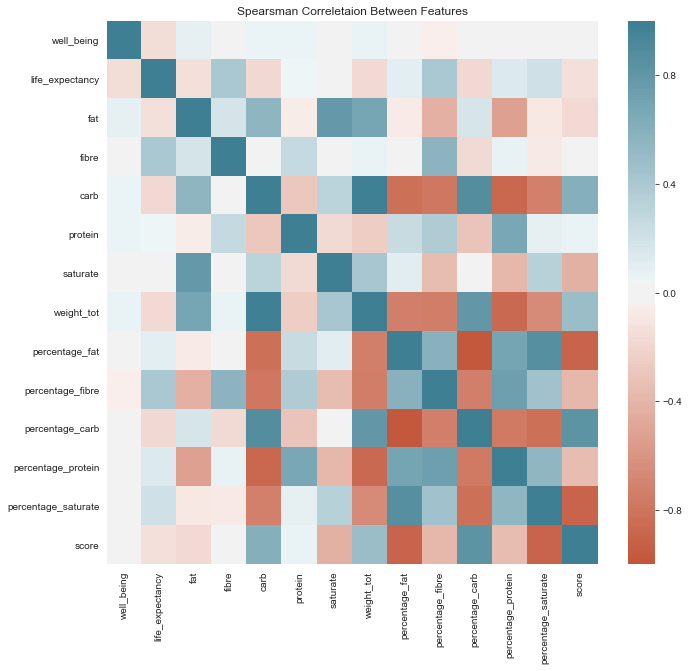

In [39]:
plt.figure(figsize=(11, 10))
heatmap = sns.heatmap(df_fda_percentage.corr(method='spearman'), vmin=-1, vmax=1, annot=False, cmap=sns.diverging_palette(20, 220, n=200))
heatmap.set_title('Spearsman Correletaion Between Features');

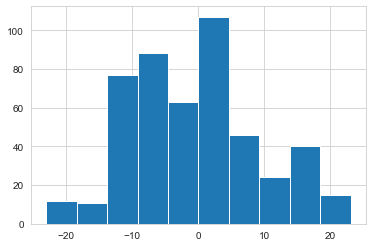

In [22]:
df_fda_percentage["well_being"].hist()

In [24]:
#Create a column if well_being > 0 --> 1
df_fda_wellness = df_fda_percentage.copy()
df_fda_wellness["well"] = 0
df_fda_wellness["well"].loc[df_fda_percentage['well_being'] > 0] = 1

In [25]:
df_fda_wellness.head()

,area_id,well_being,life_expectancy,fat,fibre,carb,protein,saturate,weight_tot,percentage_fat,percentage_fibre,percentage_carb,percentage_protein,percentage_saturate,score,well
0,E05000026,6.118185,4.251859,9.488797,1.564721,19.381951,4.977560,3.693721,30.435469,0.311768,0.051411,0.636821,0.163545,0.121362,0.979716,1
1,E05000027,-4.726708,-9.035117,9.733634,1.581960,18.950348,5.211694,3.565913,30.265942,0.321604,0.052269,0.626128,0.172197,0.117819,0.978299,0
2,E05000028,-4.813479,-7.975613,9.216310,1.572323,19.662048,5.192412,3.613582,30.450681,0.302663,0.051635,0.645701,0.170519,0.118670,0.983060,0
3,E05000029,-4.813479,-1.211477,9.700137,1.550344,20.084734,4.718184,3.961264,31.335215,0.309560,0.049476,0.640964,0.150571,0.126416,0.978490,0
4,E05000030,-4.726708,-8.051658,9.381808,1.607947,19.581403,5.307003,3.614663,30.571158,0.306884,0.052597,0.640519,0.173595,0.118238,0.982450,0


In [88]:
# Fit logistic regression model to foods
mod = smf.logit(formula='well ~ score', data=df_fda_wellness)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.689694
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   well   No. Observations:                  483
Model:                          Logit   Df Residuals:                      481
Method:                           MLE   Df Model:                            1
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:                0.003870
Time:                        16:27:04   Log-Likelihood:                -333.12
converged:                       True   LL-Null:                       -334.42
Covariance Type:            nonrobust   LLR p-value:                    0.1077
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -40.1564     25.093     -1.600      0.110     -89.338       9.025
score         40.8562     25.

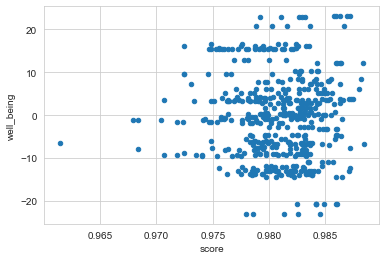

In [93]:
df_fda_wellness.plot(x='score', y='well_being', kind='scatter')

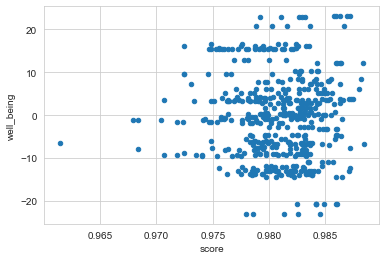

In [111]:
df_fda_wellness.plot(x='score', y='well_being', kind='scatter')

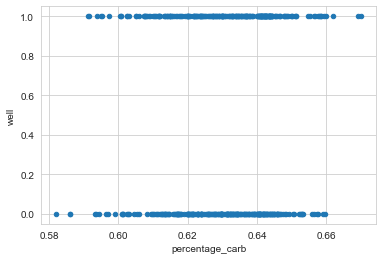

In [119]:
df_fda_wellness.plot(x='percentage_carb', y='well', kind='scatter')

In [110]:
# Fit logistic regression model to foods
mod = smf.logit(formula='well ~ percentage_carb + percentage_fat + percentage_protein + percentage_fibre', data=df_fda_wellness)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.677303
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                   well   No. Observations:                  483
Model:                          Logit   Df Residuals:                      479
Method:                           MLE   Df Model:                            3
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:                 0.02177
Time:                        16:34:42   Log-Likelihood:                -327.14
converged:                       True   LL-Null:                       -334.42
Covariance Type:            nonrobust   LLR p-value:                  0.002236
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -31.0264   8.96e+06  -3.46e-06      1.000   -1.76e+07    1.76e+07
perc

In [103]:
df_fda_wellness.head()

,area_id,well_being,life_expectancy,fat,fibre,carb,protein,saturate,weight_tot,percentage_fat,percentage_fibre,percentage_carb,percentage_protein,percentage_saturate,score,well
0,E05000026,6.118185,4.251859,9.488797,1.564721,19.381951,4.977560,3.693721,30.435469,0.311768,0.051411,0.636821,0.163545,0.121362,0.979716,1
1,E05000027,-4.726708,-9.035117,9.733634,1.581960,18.950348,5.211694,3.565913,30.265942,0.321604,0.052269,0.626128,0.172197,0.117819,0.978299,0
2,E05000028,-4.813479,-7.975613,9.216310,1.572323,19.662048,5.192412,3.613582,30.450681,0.302663,0.051635,0.645701,0.170519,0.118670,0.983060,0
3,E05000029,-4.813479,-1.211477,9.700137,1.550344,20.084734,4.718184,3.961264,31.335215,0.309560,0.049476,0.640964,0.150571,0.126416,0.978490,0
4,E05000030,-4.726708,-8.051658,9.381808,1.607947,19.581403,5.307003,3.614663,30.571158,0.306884,0.052597,0.640519,0.173595,0.118238,0.982450,0


In [173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

SEED = 1


In [174]:
def plot_validation_curve(train_scores, cv_scores, x_data, y_label='', x_label='', x_logscale=False, ylim=[0,1.1], title='Validation Curve', ax=None):    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)

    lw = 2
    
    if ax == None: 
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.ylim(ylim)
        if x_logscale:
            plt.semilogx(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)
        else:
            plt.plot(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)

        plt.fill_between(x_data, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

        if x_logscale:
            plt.semilogx(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)
        else:
            plt.plot(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)

        plt.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="navy", lw=lw)
        plt.legend(loc='best')
    else:
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_ylim(ylim)
        if x_logscale:
            ax.semilogx(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)
        else:
            ax.plot(x_data, train_scores_mean, 'o-', label="Training score", color="darkorange", lw=lw)

        ax.fill_between(x_data, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=lw)

        if x_logscale:
            ax.semilogx(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)
        else:
            ax.plot(x_data, cv_scores_mean, 'o-', label="Cross-validation score", color="navy", lw=lw)

        ax.fill_between(x_data, cv_scores_mean - cv_scores_std, cv_scores_mean + cv_scores_std, alpha=0.2, color="navy", lw=lw)
        ax.legend(loc="best")

In [159]:
df_train = df_fda_wellness.sample(frac=0.7)

X = df_fda_wellness[["score", "percentage_fat", "percentage_fibre", "percentage_carb", "percentage_protein", "percentage_saturate"]]
y = df_fda_wellness["well"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=SEED)

In [163]:
# Use a Random Forest Classifier to predict labels
N_values  = np.array([int(i) for i in np.linspace(5.0, 200, 5)])
model     = RandomForestClassifier(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(model, X_train, y_train,
                                                   scoring='accuracy',
                                                   param_name = "n_estimators", 
                                                   param_range = N_values,
                                                   cv=cv_schema)

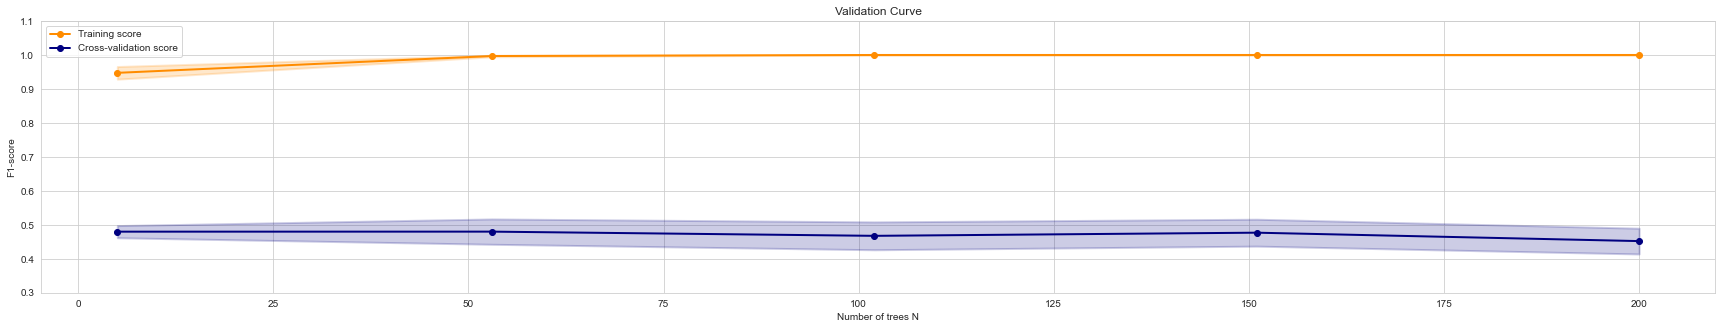

In [164]:
# Plot a validation curve across levels of K
plt.figure(figsize=(30,5))
plot_validation_curve(train_scores_val,
                      cv_scores_val,
                      N_values, y_label='F1-score',
                      ylim = [0.3, 1.1],
                      x_label='Number of trees N', 
                      x_logscale=False)


In [165]:
RF = RandomForestClassifier(n_estimators=100, n_jobs =-1, random_state=SEED)
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

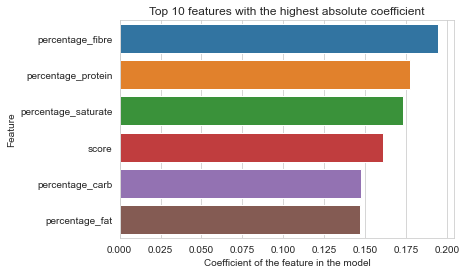

In [167]:
df = pd.DataFrame(RF.feature_importances_, index=["score", "percentage_fat", "percentage_fibre", "percentage_carb", "percentage_protein", "percentage_saturate"])

sns.barplot(y='index', x=0, orient="h", data=df.apply(abs).reset_index().sort_values(by=0, ascending=False)[:10])
plt.xlabel('Coefficient of the feature in the model')
plt.ylabel('Feature')
plt.title('Top 10 features with the highest absolute coefficient')
plt.show()

In [176]:
def plot_confusion_matrix(cm, title='Confusion Matrix', ax=None):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition. 
    The cm parameter can be an object created by the sklearn confusion_matrix() function.
    
    Args:
        cm         this must be a sklearn confusion matrix 
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    sns.heatmap(data=pd.DataFrame(cm), vmin=0, annot=True, square=True, cmap=plt.cm.Reds, fmt='g', ax=ax)
    if ax == None:
        plt.xlabel('Predicted label')
        plt.ylabel('Actual label')
        plt.title(title)
    else:
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('Actual label')
        ax.set_title(title)

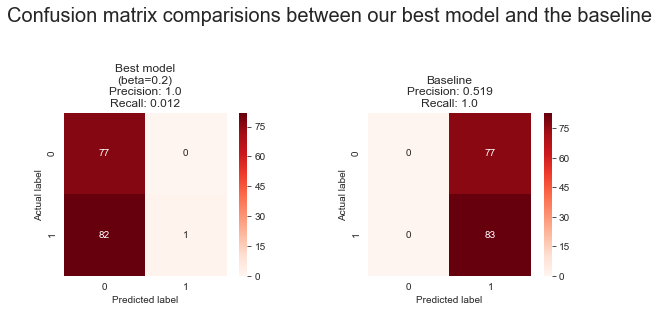

In [177]:
fig, axes = plt.subplots(1,2,figsize=(10,3))
# Best random forest
best_thresh = 0.7755

RF = RandomForestClassifier(n_estimators=700, n_jobs =-1, random_state=SEED)
RF.fit(X_train, y_train)
y_hat = RF.predict_proba(X_test)[:,1] > best_thresh
cm = confusion_matrix(y_test, y_hat)
precision = precision_score(y_test, y_hat)
recall = recall_score(y_test, y_hat)
title = "Best model\n(beta=0.2)\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))
plot_confusion_matrix(cm, title=title, ax=axes[0])

# Baseline
y_hat_baseline = np.full_like(y_test, 1)
cm = confusion_matrix(y_test, y_hat_baseline)
precision = precision_score(y_test, y_hat_baseline)
recall = recall_score(y_test, y_hat_baseline)
title = "Baseline\nPrecision: {}\nRecall: {}".format(round(precision, 3), round(recall, 3))

plot_confusion_matrix(cm, title=title, ax=axes[1])

plt.suptitle('Confusion matrix comparisions between our best model and the baseline', y=1.37, x=0.55, fontsize=20)

plt.show()

In [ ]:
# Use a KNN Classifier to predict labels

K_values  = np.array([int(i) for i in np.linspace(5.0, 100.0, 20)])
model     = KNeighborsClassifier(n_jobs=-1)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

In [26]:
#Create a column if well_being > 0 --> 1
df_healthy_well = df_healthy.copy()
df_healthy_well["well"] = 0
df_healthy_well["well"].loc[df_healthy['well_being'] > 0] = 1

In [27]:
df_healthy_well.head()

,area_id,well_being,life_expectancy,fat,saturate,salt,sugar,protein,carb,fibre,...,f_tea_coffee,f_water,f_wine,percentage_fat,percentage_protein,percentage_carb,percentage_fibre,percentage_alcohol,score,well
0,E05000026,6.118185,4.251859,9.488797,3.693721,0.583240,10.966213,4.977560,19.381951,1.564721,...,0.005945,0.042942,0.007917,45.640000,10.640657,41.433292,1.544686,0.741364,0.125700,1
1,E05000027,-4.726708,-9.035117,9.733634,3.565913,0.568184,10.514427,5.211694,18.950348,1.581960,...,0.005572,0.041258,0.007355,46.439549,11.051200,40.183491,1.546797,0.778963,0.130958,0
2,E05000028,-4.813479,-7.975613,9.216310,3.613582,0.610536,10.690272,5.192412,19.662048,1.572323,...,0.006076,0.043609,0.009281,44.389378,11.114978,42.088964,1.562220,0.844460,0.138758,0
3,E05000029,-4.813479,-1.211477,9.700137,3.961264,0.533180,12.938606,4.718184,20.084734,1.550344,...,0.006578,0.046902,0.007344,45.759214,9.892203,42.109906,1.503467,0.735209,0.152978,0
4,E05000030,-4.726708,-8.051658,9.381808,3.614663,0.566784,11.332898,5.307003,19.581403,1.607947,...,0.006638,0.039688,0.009738,44.880395,11.283322,41.632398,1.575264,0.628621,0.139938,0


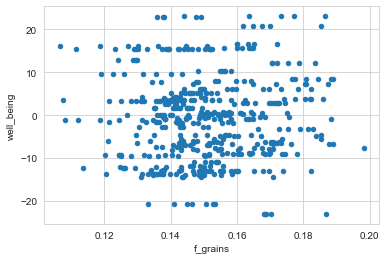

In [28]:
df_healthy_well.plot(x='f_grains', y='well_being', kind='scatter')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(df_healthy_well, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

In [205]:
df_healthy_well.columns[0]

'area_id'

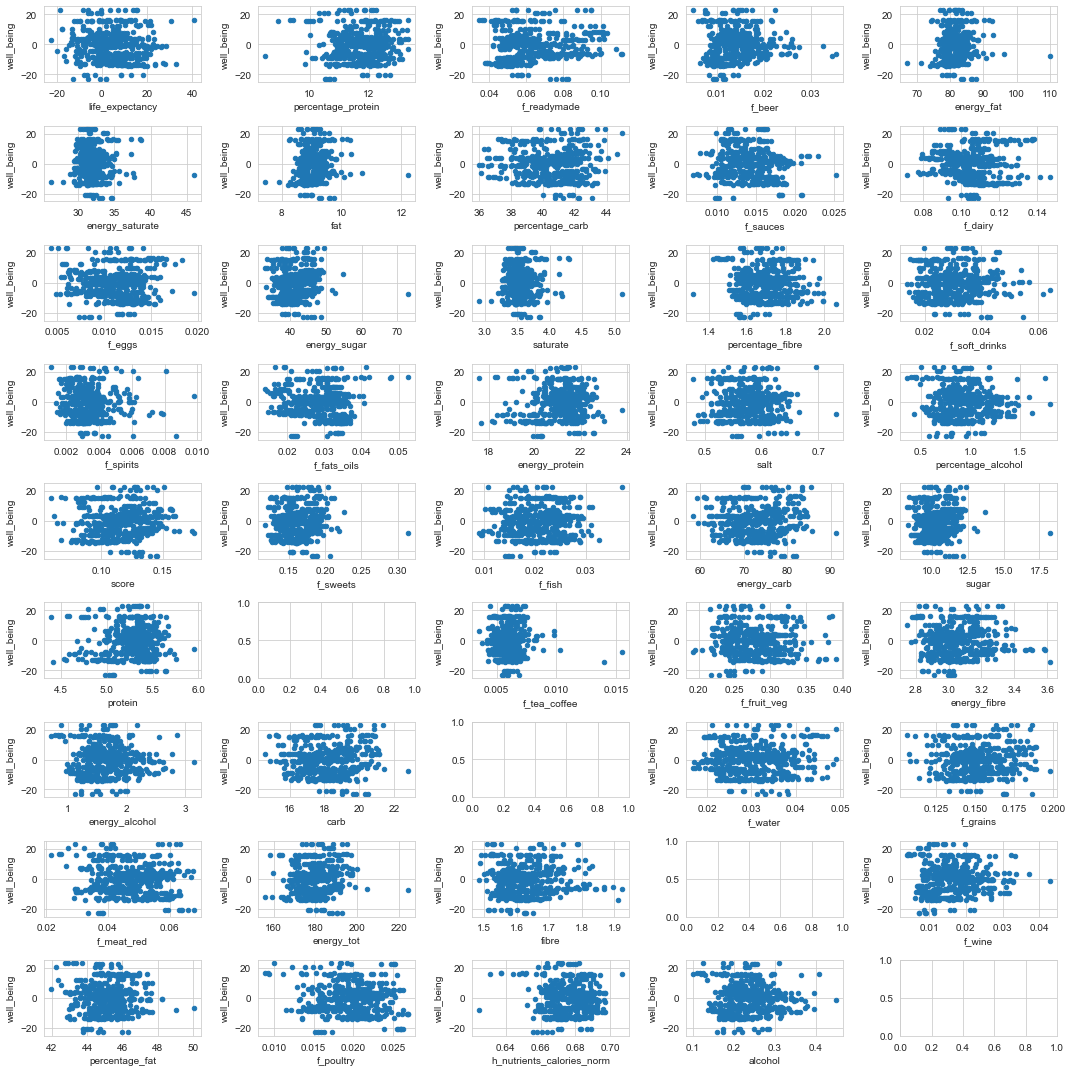

In [31]:

fig, axes = plt.subplots(nrows = 9, ncols=5, tight_layout=True, figsize=(15, 15))

for i, feature in enumerate(df_healthy_well.columns[2:-1]):
    df_healthy_well.plot(x=feature, y='well_being', kind='scatter', ax=axes[i%9][i%5])
    

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


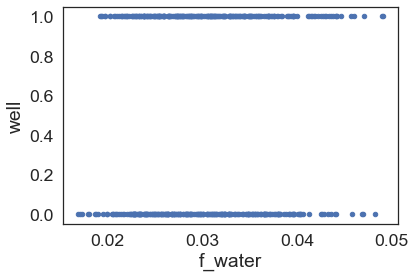

In [217]:
df_healthy_well.plot(x="f_water", y="well", kind='scatter')